In [221]:
%matplotlib inline
from qiskit import QuantumCircuit, transpile, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.visualization import plot_distribution, plot_histogram, plot_bloch_multivector
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from utils import get_image_path
from scipy.optimize import minimize

![diagram](./assets/buckshot-roulette-diagram.png)

In [58]:
player_strategy = lambda bullets, fakes: "himself" if(bullets == fakes or fakes > bullets) else "shoot"
dealer_strategy = lambda bullets, fakes:  "himself" if np.random.randint(2) else "shoot"

In [81]:
def gun(bullets, fakes) -> bool:
    v = bullets + fakes
    r = np.random.randint(1, v+1)
    return r <= bullets
    

def play(strategies:dict, players:list, total_bullets:int, total_fakes:int, debug:bool=False) -> pd.DataFrame:
    lives = {
        "player":0,
        "dealer":0
    }

    actual_player = players[0]
    oponent = players[1]
    rounds = 0
    while(total_bullets):
        player = strategies[actual_player]
        action = player(total_bullets, total_fakes)
        shot = gun(total_bullets, total_fakes)

        if(debug):
            print(f"playing: {actual_player}")
            print(f"oponent: {oponent}")
            print(f"action: {action}")
            print(f"shot: {shot}")
        

        if(action == "shoot" and shot):
            lives[oponent] -=1
            total_bullets -=1
            actual_player = players[0]
            oponent = players[1]

        elif(action == "shoot" and not shot):
            total_fakes -=1
            actual_player,oponent = oponent,actual_player

        elif(action == "himself" and shot):
            lives[actual_player] -=1
            total_bullets -=1
            actual_player = players[0]
            oponent = players[1]

        else:
            total_fakes -=1            

        if(debug):
            print(lives, end="\n\n")

        rounds += 1

    if(lives['player'] > lives['dealer']):
        return 'player', rounds
    elif(lives['dealer'] > lives['player']):
        return 'dealer', rounds
    else:
        return 'draw', rounds


In [82]:
play({"player":player_strategy, "dealer":dealer_strategy}, ("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)

playing: player
oponent: dealer
action: himself
shot: False
{'player': 0, 'dealer': 0}

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



('dealer', 2)

In [94]:
def get_experiment_results(n:int, players_strategies:dict, players:list, total_bullets:int, total_fakes:int):
    df = pd.DataFrame(columns=("total_player", "total_dealer"))
    n_rounds = pd.Series()

    j = 1000
    for i in range(n):
        results = {"player":0, "dealer":0}
        for _ in range(j):
            result, rounds = play(players_strategies, players, total_bullets, total_fakes)
            results[result]+=1
            n_rounds.loc[j*i + j] = rounds
        df.loc[i] = {"total_player":results['player'], "total_dealer":results['dealer']}
    return df, n_rounds

1    337
3    334
2    329
Name: count, dtype: int64


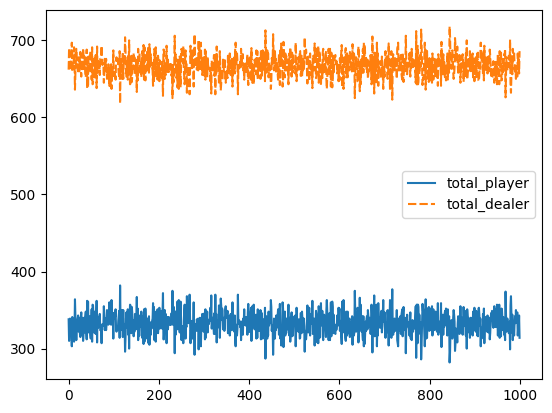

In [125]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

3    351
2    334
1    315
Name: count, dtype: int64


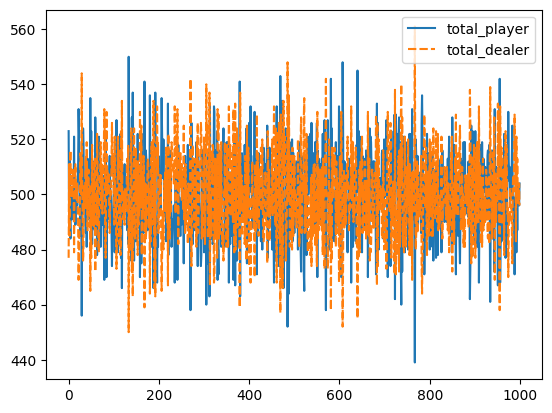

In [126]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":dealer_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

2    349
3    330
1    321
Name: count, dtype: int64


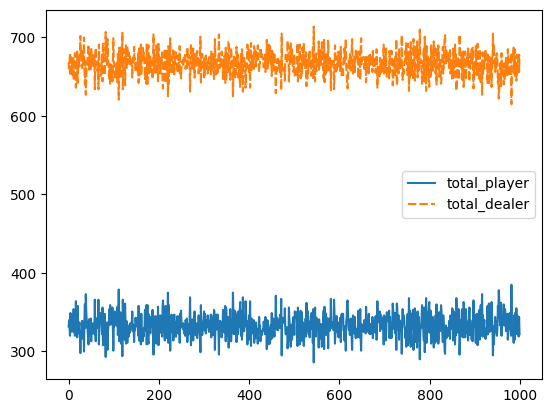

In [127]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_strategy, "dealer":player_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [75]:
def player_start_himself_strategy(bullets, fakes):
    if(bullets == 1 and fakes == 2):
        return 'himself'

    elif(bullets == fakes):
        return 'shoot' if np.random.randint(2) else "himself"

    return 'shoot'

2    366
1    331
3    303
Name: count, dtype: int64


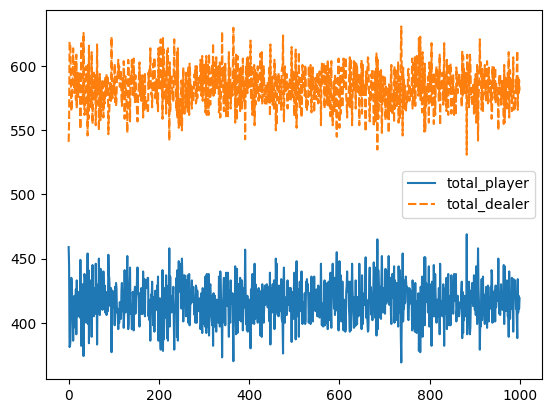

In [128]:
df,rounds = get_experiment_results(n=1000, players_strategies={"player":player_start_himself_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [79]:
def player_optimal_strategy(bullets, fakes):
    if(bullets == 1 and fakes == 2):
        return 'shoot'

    elif(bullets == fakes):
        return 'shoot' if np.random.randint(2) else "himself"

    return 'shoot'

2    1056
1    1001
3     943
Name: count, dtype: int64


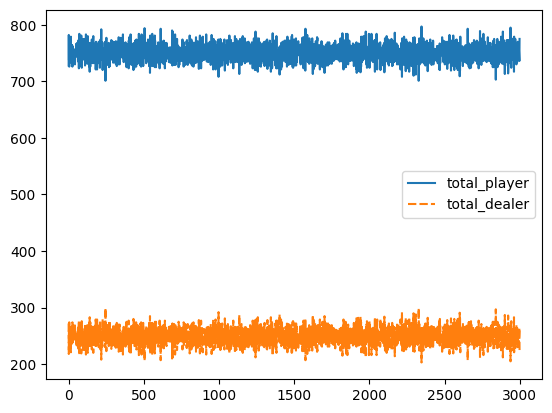

In [130]:
df,rounds = get_experiment_results(n=3000, players_strategies={"player":player_optimal_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2)
print(rounds.value_counts())
sns.lineplot(data=df)
plt.show()

In [135]:
df,rounds = play({"player":player_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the first strategy, there're some possible ways to finish the game

# player shoot himself (first round)
# dealer shoot himself (second round)
# dealer shoot the player (second round)
# player shoot (third round)

# so the player loses most part of the time

playing: player
oponent: dealer
action: himself
shot: False
{'player': 0, 'dealer': 0}

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



2

In [148]:
df,rounds = play({"player":player_start_himself_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the second strategy, there're some possible ways to finish the game

# player shoot himself (first round)
# player shoot himself (second round)
# player shoot the dealer (second round)
# dealer shoot the player (third round)
# dealer shoot himself (third round)

# so the player loses most part of the time

playing: player
oponent: dealer
action: himself
shot: True
{'player': -1, 'dealer': 0}



1

In [155]:
df,rounds = play({"player":player_optimal_strategy, "dealer":dealer_strategy}, players=("player", "dealer"), total_bullets=1, total_fakes=2, debug=True)
rounds

# in the third strategy, there're some possible ways to finish the game

# player shoot the dealer (first round)
# dealer shoot himself (second round)
# dealer shoot the player (second round)
# dealer shoot himself (third round)
# dealer shoot the player (third round)
# player shoot the dealer(third round)

# so the dealer loses most part of the time
# as in the first play the player chooses to shoot the dealer, he has more chances to live, once he's removed one of the dying chances

playing: player
oponent: dealer
action: shoot
shot: True
{'player': 0, 'dealer': -1}



1

---

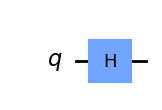

In [2]:
player = QuantumCircuit(1, name="Player")
player.h(0)
player.draw('mpl', style="clifford")

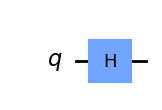

In [3]:
dealer = QuantumCircuit(1, name="Dealer")
dealer.h(0)
player.draw('mpl', style="clifford")

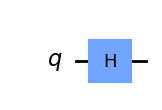

In [4]:
gun = QuantumCircuit(1, name="shoot")
gun.h(0)
gun.draw('mpl', style='clifford')

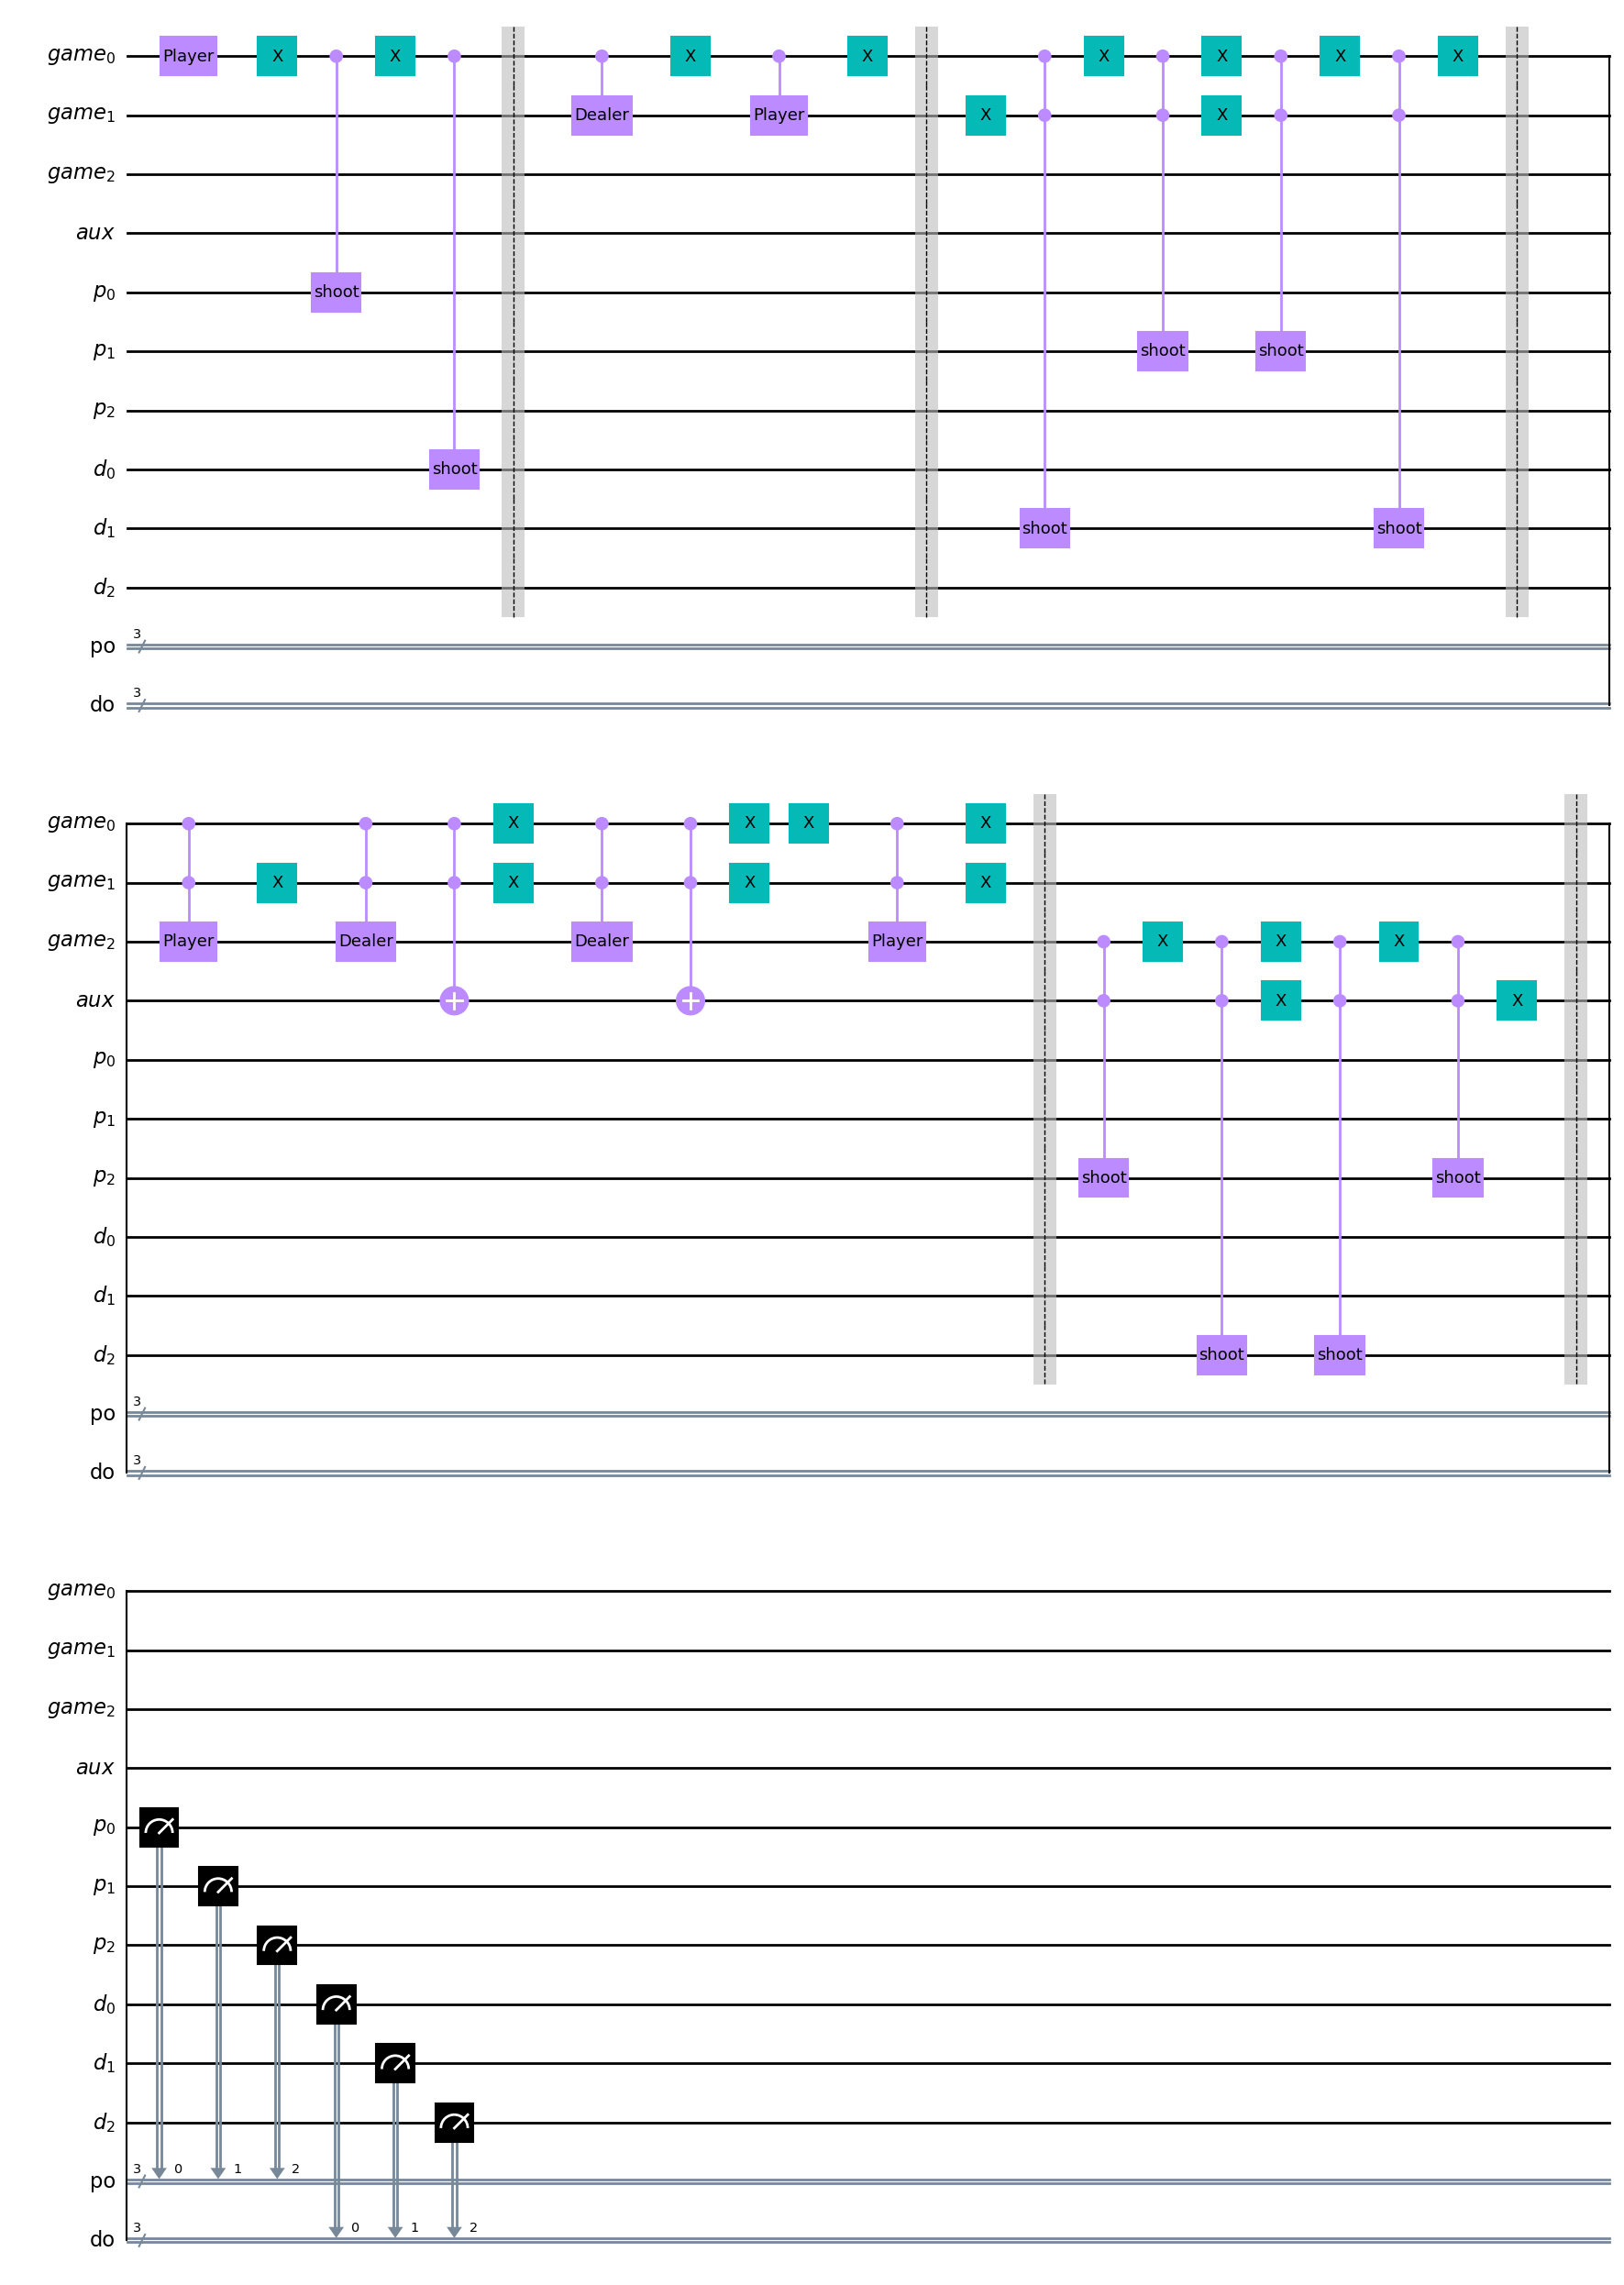

In [207]:
def buckshot_roulette(player, dealer, gun):
    player_gate = player.to_gate()
    player_controlled_gate = player.to_gate().control(1)
    player_two_controlled_gate = player.to_gate().control(2)
    
    dealer_controlled_gate = dealer.to_gate().control(1)
    dealer_two_controlled_gate = dealer.to_gate().control(2)
    
    gun_controlled_gate = gun.to_gate().control(1)
    gun_two_controlled_gate = gun.to_gate().control(2)
    
    player_life  = QuantumRegister(3, name="p") 
    dealer_life  = QuantumRegister(3, name="d")
    game = QuantumRegister(3, name="game")
    player_life_out = ClassicalRegister(3, name="po")
    dealer_life_out = ClassicalRegister(3, name="do")
    aux = AncillaRegister(1, name="aux")
    
    qc = QuantumCircuit(game, aux, player_life, dealer_life, player_life_out, dealer_life_out)
    
    qc.append(player.copy(), [game[0]])
    qc.x(game[0])
    qc.append(gun_controlled_gate.copy(), [game[0], player_life[0]])
    qc.x(game[0])
    qc.append(gun_controlled_gate.copy(), [game[0], dealer_life[0]])
    
    #next_player
    # 0 = player, 1 = dealer
    
    qc.barrier()
    
    qc.append(dealer_controlled_gate, [game[0], game[1]])
    qc.x(game[0])
    qc.append(player_controlled_gate, [game[0], game[1]])
    qc.x(game[0])
    qc.barrier()
    
    qc.x(game[1])
    qc.append(gun_two_controlled_gate, [game[0], game[1], dealer_life[1]])
    qc.x(game[0])
    qc.append(gun_two_controlled_gate, [game[0], game[1], player_life[1]])
    qc.x(game[0])
    
    qc.x(game[1])
    qc.append(gun_two_controlled_gate, [game[0], game[1], player_life[1]])
    qc.x(game[0])
    qc.append(gun_two_controlled_gate, [game[0], game[1], dealer_life[1]])
    qc.x(game[0])
    
    qc.barrier()
    
    qc.append(player_two_controlled_gate, [game[0], game[1], game[2]])
    
    qc.x(game[1])
    qc.append(dealer_two_controlled_gate, [game[0], game[1], game[2]])
    qc.ccx(game[0], game[1], aux)
    qc.x(game[1])
    
    qc.x(game[0])
    qc.append(dealer_two_controlled_gate, [game[0], game[1], game[2]])
    qc.ccx(game[0], game[1], aux)
    qc.x(game[0])
    
    qc.x([game[0], game[1]])
    qc.append(player_two_controlled_gate, [game[0], game[1], game[2]])
    qc.x([game[0], game[1]])
    qc.barrier()
    
    qc.append(gun_two_controlled_gate, [aux, game[2], player_life[2]])
    qc.x(game[2])
    qc.append(gun_two_controlled_gate, [aux, game[2], dealer_life[2]])
    qc.x(game[2])
    qc.x(aux)
    qc.append(gun_two_controlled_gate, [aux, game[2], dealer_life[2]])
    qc.x(game[2])
    qc.append(gun_two_controlled_gate, [aux, game[2], player_life[2]])
    qc.x(aux)
    
    
    qc.barrier()
    qc.measure(player_life, player_life_out)
    qc.measure(dealer_life, dealer_life_out)
    
    return qc


qc = buckshot_roulette(player, dealer, gun)
qc.draw('mpl', style="clifford", filename=get_image_path("quantum_buckshot_roulette.png"))

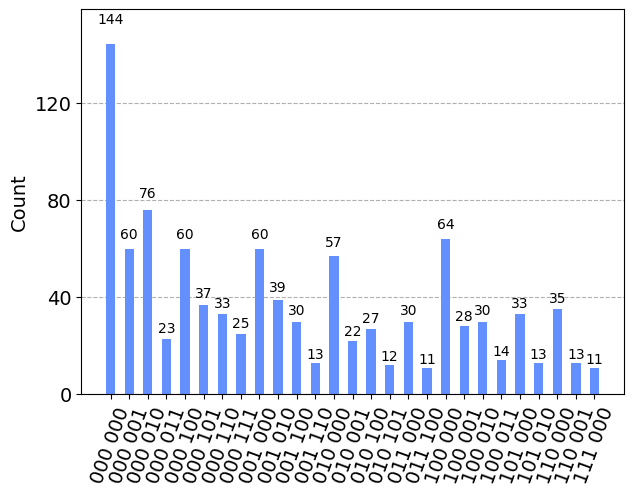

In [208]:
sim = AerSimulator()
transpiled_qc = transpile(buckshot_roulette(player, dealer, gun), sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
plot_histogram(result)

In [209]:
def parse_results(results):
    wins = {'dealer':0, 'player':0}
    for d,v in results.items():
        #v_bin = f"{v:06b}"
        bin_dealer, bin_player = d[:3], d[4:]

        #first_match
        first_dealer, first_player = bin_dealer[-1], bin_player[-1]
        #second_match
        second_dealer, second_player = bin_dealer[-2], bin_player[-2]
        #third_match
        third_dealer, third_player = bin_dealer[-3], bin_player[-3]

        if(first_dealer != first_player):
            winner = "dealer" if first_dealer == '1' else "player"
            wins[winner]+=v
            continue
            
        if(second_dealer != second_player):
            winner = "dealer" if second_dealer == '1' else "player"
            wins[winner]+=v
            continue
            
        if(third_dealer != third_player):
            winner = "dealer" if third_dealer == '1' else "player"
            wins[winner]+=v
            continue
        
    return wins    
    
parse_results(result)

{'dealer': 423, 'player': 433}

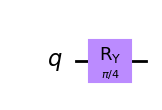

In [217]:
player_2 = QuantumCircuit(1)
player_2.ry(np.pi/4, 0)
player_2.draw('mpl', style='clifford')

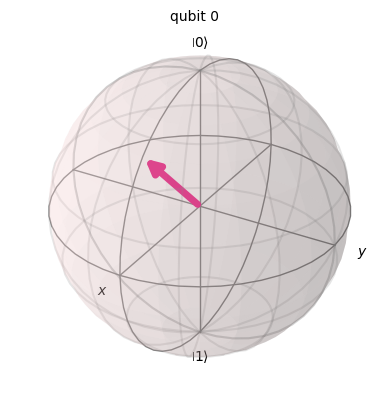

In [218]:
plot_bloch_multivector(player_2)

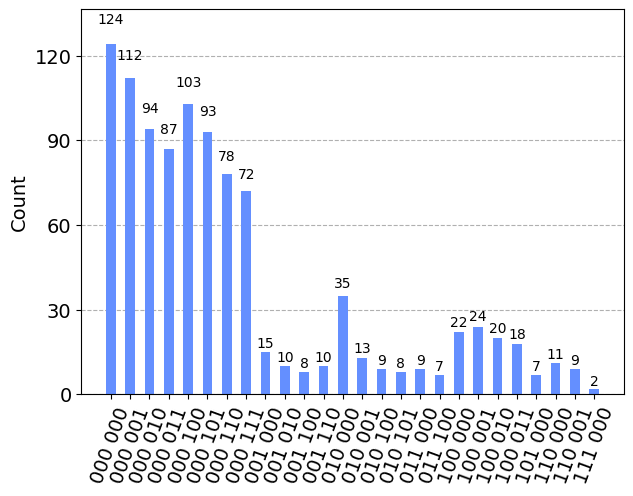

In [219]:
sim = AerSimulator()
transpiled_qc = transpile(buckshot_roulette(player_2, dealer, gun), sim)
result = sim.run(transpiled_qc, shots=1000).result().get_counts()
plot_histogram(result)

In [220]:
parse_results(result)

{'dealer': 145, 'player': 731}

In [233]:
def obj(x):
    print(x)
    return 1000.3-x
    
minimize(obj, [0.3])

[0.3]
[0.30000001]
[1.3]
[1.30000001]
[5.3]
[5.30000001]
[21.3]
[21.30000001]
[85.3]
[85.30000001]
[341.3]
[341.30000001]
[1365.3]
[1365.30000001]
[5461.3]
[5461.30000001]
[21845.3]
[21845.30000001]
[87381.3]
[87381.30000001]
[349525.3]
[349525.30000001]
[1398101.3]
[1398101.30000001]
[5592405.3]
[5592405.30000001]
[22369621.3]
[22369621.30000002]
[89478485.3]
[89478485.30000001]
[3.57913941e+08]
[3.57913947e+08]
[1.43165577e+09]
[1.43165579e+09]
[5.72662306e+09]
[5.72662315e+09]
[2.29064922e+10]
[2.29064926e+10]
[9.1625969e+10]
[9.16259703e+10]
[3.66503876e+11]
[3.66503881e+11]
[1.4660155e+12]
[1.46601553e+12]
[5.86406201e+12]
[5.8640621e+12]
[2.34562481e+13]
[2.34562484e+13]
[9.38249922e+13]
[9.38249936e+13]
[3.75299969e+14]
[3.75299975e+14]
[1.50119988e+15]
[1.5011999e+15]
[6.0047995e+15]
[6.00479959e+15]
[2.4019198e+16]
[2.40191984e+16]
[9.60767921e+16]
[9.60767935e+16]
[3.84307168e+17]
[3.84307174e+17]
[1.53722867e+18]
[1.5372287e+18]
[6.14891469e+18]
[6.14891478e+18]
[2.45956588e

/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/scipy/optimize/_optimize.py:241: RuntimeWarning: overflow encountered in square
  return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)
/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/scipy/optimize/_optimize.py:241: RuntimeWarning: overflow encountered in square
  return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)
/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/scipy/optimize/_optimize.py:241: RuntimeWarning: overflow encountered in square
  return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)
/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/scipy/optimize/_optimize.py:241: RuntimeWarning: overflow encountered in square
  return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)
/home/alexandre/.asdf/installs/python/miniconda3

[1.81927088e+93]
[1.81927091e+93]
[7.27692167e+93]
[7.27692178e+93]
[2.91075248e+94]
[2.91075253e+94]
[1.16429937e+95]
[1.16429939e+95]
[4.65719588e+95]
[4.65719595e+95]
[1.86287819e+96]
[1.86287822e+96]
[7.4515126e+96]
[7.45151271e+96]
[2.98060502e+97]
[2.98060507e+97]
[1.19224201e+98]
[1.19224203e+98]
[4.76896803e+98]
[4.7689681e+98]
[1.90758721e+99]
[1.90758724e+99]
[7.63034884e+99]
[7.63034896e+99]
[3.05213954e+100]
[3.05213958e+100]
[1.22085582e+101]
[1.22085583e+101]
[4.88342326e+101]
[4.88342333e+101]
[1.9533693e+102]
[1.95336933e+102]
[7.81347722e+102]
[7.81347733e+102]
[3.12539089e+103]
[3.12539093e+103]
[1.25015635e+104]
[1.25015637e+104]
[5.00062542e+104]
[5.00062549e+104]
[2.00025017e+105]
[2.0002502e+105]
[8.00100067e+105]
[8.00100079e+105]
[3.20040027e+106]
[3.20040032e+106]
[1.28016011e+107]
[1.28016013e+107]
[5.12064043e+107]
[5.12064051e+107]
[2.04825617e+108]
[2.0482562e+108]
[8.19302469e+108]
[8.19302481e+108]
[3.27720987e+109]
[3.27720992e+109]
[1.31088395e+110]
[1.

/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/scipy/optimize/_optimize.py:241: RuntimeWarning: overflow encountered in square
  return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)
/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/scipy/optimize/_optimize.py:241: RuntimeWarning: overflow encountered in square
  return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)
/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/scipy/optimize/_optimize.py:241: RuntimeWarning: overflow encountered in square
  return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)
/home/alexandre/.asdf/installs/python/miniconda3-4.7.12/envs/quantum-oracles/lib/python3.8/site-packages/scipy/optimize/_optimize.py:241: RuntimeWarning: overflow encountered in square
  return np.sum(np.abs(x)**ord, axis=0)**(1.0 / ord)
/home/alexandre/.asdf/installs/python/miniconda3

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -3.392118110990971e+155
        x: [ 3.392e+155]
      nit: 47
      jac: [-1.000e+00]
 hess_inv: [[       inf]]
     nfev: 7037
     njev: 3518